In [1]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Could not load libcorrections.


In [2]:
scan_name ="FeBpy_monoscan_350nm_10uJ_500fs_005"
#scan_name ="CytC_Fe2_7122eV_delayscan_002"

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 534G
-rw-r--r--.   1 17803 p17803  18G Jan 31 18:27 FeBpy_monoscan_350nm_10uJ_500fs_005_step0000.JF02T09V01.h5
-rw-r--r--.   1 root  p17803 6.2M Jan 31 18:28 FeBpy_monoscan_350nm_10uJ_500fs_005_step0000.BSREAD_CA.h5
-rw-r--r--.   1 17803 p17803  18G Jan 31 18:29 FeBpy_monoscan_350nm_10uJ_500fs_005_step0001.JF02T09V01.h5
-rw-r--r--.   1 root  p17803 827M Jan 31 18:29 FeBpy_monoscan_350nm_10uJ_500fs_005_step0000.BSREAD.h5
-rw-r--r--.   1 root  p17803 6.2M Jan 31 18:29 FeBpy_monoscan_350nm_10uJ_500fs_005_step0001.BSREAD_CA.h5
-rw-r--r--.   1 17803 p17803  18G Jan 31 18:30 FeBpy_monoscan_350nm_10uJ_500fs_005_step0002.JF02T09V01.h5
-rw-r--r--.   1 root  p17803 827M Jan 31 18:30 FeBpy_monoscan_350nm_10uJ_500fs_005_step0001.BSREAD.h5
-rw-r--r--.   1 root  p17803 6.3M Jan 31 18:31 FeBpy_monoscan_350nm_10uJ_500fs_005_step0002.BSREAD_CA.h5
-rw-r--r--.   1 17803 p17803  18G Jan 31 18:31 FeBpy_monoscan_350nm_10uJ_500fs_005_step0003.JF02T09V01.h5
-rw-r--r--.   1 root  p17803 827M Jan 31 18:32

ra-c-002.psi.ch
There are 87 files in the folder /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/


# Load one step and filter some data from I0

In [3]:
f ="FeBpy_monoscan_350nm_10uJ_500fs_005_step0000.BSREAD.h5"
fn = DIR + f

(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
 DataTrans_pump_shot, DataTrans_unpump_shot) = load_XAS_pulseID(fn, channel_delay, 25, 12.5)

IzeroFEL_pump_original = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_original = IzeroFEL_unpump_shot.copy()
print (np.median(IzeroFEL_pump_shot) - 1.2*(np.std(IzeroFEL_pump_shot)))

conditionPumpMax = IzeroFEL_pump_shot < np.median(IzeroFEL_pump_shot)+2*(np.std(IzeroFEL_pump_shot))
conditionPumpMin = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-2*(np.std(IzeroFEL_pump_shot))

conditionUnPumpMax = IzeroFEL_unpump_shot < np.median(IzeroFEL_unpump_shot)+2*(np.std(IzeroFEL_unpump_shot))
conditionUnPumpMin = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-2*(np.std(IzeroFEL_unpump_shot))

conditionGeneral = IzeroFEL_pump_shot > 1000
conditionGeneral2 = IzeroFEL_unpump_shot > 1000

IzeroFEL_pump_shot = IzeroFEL_pump_shot[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

IzeroFEL_pump_shot = np.asarray(IzeroFEL_pump_shot)
IzeroFEL_pump_original = np.asarray(IzeroFEL_pump_original)



2750.9744114678647


<IPython.core.display.Javascript object>


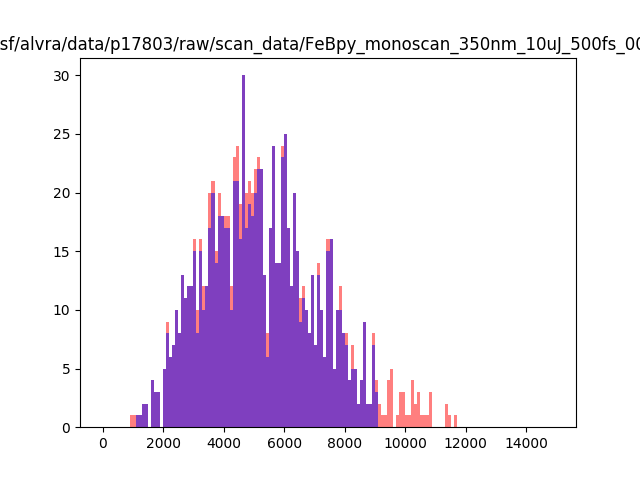

1000 906


In [4]:
num_bins = 100
plt.figure()
plt.hist(IzeroFEL_pump_original, bins =np.arange(0,15000,100), facecolor='red', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)
#plt.hist(Izero_unpump_original, bins =np.arange(0,15000,100), facecolor='blue', alpha=0.5)

plt.title(DIR)
plt.show()
print (IzeroFEL_pump_original.size, IzeroFEL_pump_shot.size)

# Load time scan

In [5]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

DataTrans_pump = []
DataTrans_unpump = []
err_DataTrans_pump = []
err_DataTrans_unpump = []

Pump_probe = []
err_Pump_probe = []

Delay_mm = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: # and i!=39:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Delay_shot, \
         DataTrans_pump_shot, DataTrans_unpump_shot) = load_XAS_pulseID(filename, channel_delay, 25, 12.5)
              
        threshold_pump = IzeroFEL_pump_shot > 1000
        threshold_unpump = IzeroFEL_unpump_shot > 1000 
        condition_pump = IzeroFEL_pump_shot > np.median(IzeroFEL_pump_shot)-1.2*(np.std(IzeroFEL_pump_shot))
        condition_unpump = IzeroFEL_unpump_shot > np.median(IzeroFEL_unpump_shot)-1.2*(np.std(IzeroFEL_unpump_shot))

        DataFluo_pump_shot = DataFluo_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_pump_shot = IzeroFEL_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_pump_shot = DataTrans_pump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
              
        DataFluo_unpump_shot = DataFluo_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        DataTrans_unpump_shot = DataTrans_unpump_shot[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
    
              
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        DataTrans_pump_shot_norm = DataTrans_pump_shot / IzeroFEL_pump_shot
        DataTrans_unpump_shot_norm = DataTrans_unpump_shot / IzeroFEL_unpump_shot
              
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        DataFluo_pump.append(DataFluo_pump_shot_norm.mean())
        DataFluo_unpump.append(DataFluo_unpump_shot_norm.mean())
        DataTrans_pump.append(DataTrans_pump_shot_norm.mean())
        DataTrans_unpump.append(DataTrans_unpump_shot_norm.mean())
        
        Pump_probe.append(Pump_probe_shot.mean())
        
        err_DataFluo_pump.append(DataFluo_pump_shot_norm.std()/np.sqrt(DataFluo_pump_shot_norm.size))
        err_DataFluo_unpump.append(DataFluo_unpump_shot_norm.std()/np.sqrt(DataFluo_unpump_shot_norm.size))
        err_DataTrans_pump.append(DataTrans_pump_shot_norm.std()/np.sqrt(DataTrans_pump_shot_norm.size))
        err_DataTrans_unpump.append(DataTrans_unpump_shot_norm.std()/np.sqrt(DataTrans_unpump_shot_norm.size))
              
        err_Pump_probe.append(Pump_probe_shot.std()/np.sqrt(Pump_probe_shot.size))
               
        Delay_shot = [x for x in Delay_shot if (np.abs(x) > 0)]
        Delay_mm.append(np.mean(Delay_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
DataTrans_pump = np.asarray(DataTrans_pump)
DataTrans_unpump = np.asarray(DataTrans_unpump)
              
Pump_probe = np.asarray(Pump_probe)
err_Pump_probe = np.asarray(err_Pump_probe)
              
err_DataFluo_pump = np.asarray(err_DataFluo_pump)
err_DataFluo_unpump = np.asarray(err_DataFluo_unpump)
err_DataTrans_pump = np.asarray(err_DataTrans_pump)
err_DataTrans_unpump = np.asarray(err_DataTrans_unpump)
            
Delay_mm = np.asarray(Delay_mm)

print ("Job done!")


/sf/alvra/data/p17803/res/scan_info/FeBpy_monoscan_350nm_10uJ_500fs_005_scan_info.json
Processing 29 files
step 1 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/FeBpy_monoscan_350nm_10uJ_500fs_005_step0000.BSREAD.h5
step 2 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/FeBpy_monoscan_350nm_10uJ_500fs_005_step0001.BSREAD.h5
step 3 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/FeBpy_monoscan_350nm_10uJ_500fs_005_step0002.BSREAD.h5
step 4 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/FeBpy_monoscan_350nm_10uJ_500fs_005_step0003.BSREAD.h5
step 5 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/FeBpy_monoscan_350nm_10uJ_500fs_005_step0004.BSREAD.h5
step 6 of 29 : Processing /sf/alvra/data/p17803/raw/scan_data/FeBpy_monoscan_350nm_10uJ_500fs_005/FeBpy_monoscan_350nm_10uJ_500f

# Plot time scans

<IPython.core.display.Javascript object>


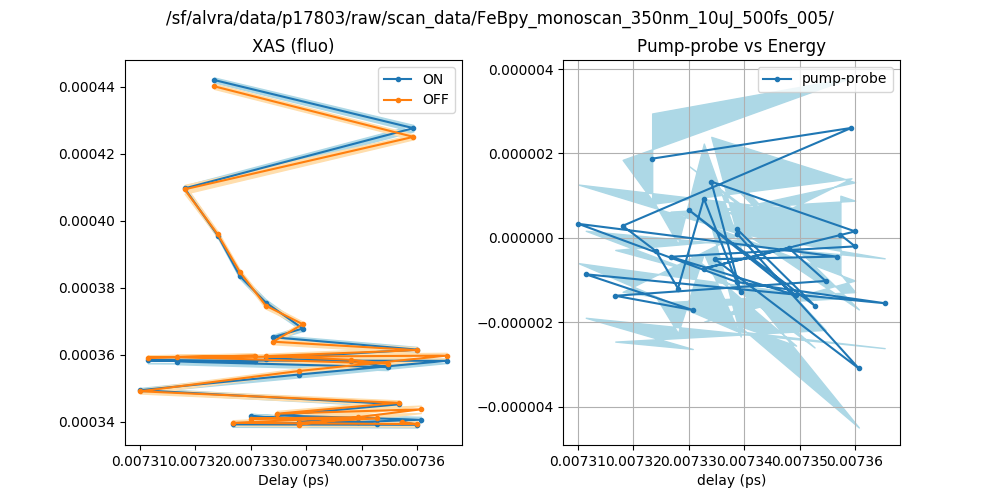

In [6]:
Timezero = 149.418   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !


plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')
low_err_pump = DataFluo_pump - err_DataFluo_pump
high_err_pump = DataFluo_pump + err_DataFluo_pump
low_err_unpump = DataFluo_unpump - err_DataFluo_unpump
high_err_unpump = DataFluo_unpump + err_DataFluo_unpump
low_err_pumpprobe = (Pump_probe) - np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)
high_err_pumpprobe = (Pump_probe) + np.sqrt(err_DataFluo_pump**2+err_DataFluo_unpump**2)

plt.subplot(1,2,1)
plt.plot(Delay_ps, scale*DataFluo_pump, label="ON",marker='.')
plt.plot(Delay_ps, scale*DataFluo_unpump, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Delay_ps, scale*(Pump_probe), label="pump-probe",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pumpprobe, scale*high_err_pumpprobe, color='lightblue')
plt.grid()
plt.xlabel("delay (ps)")
plt.gca().set_title('Pump-probe vs Energy')
plt.legend(loc="best")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()